# SWU Hackathon Image Datamining

Install environment stuff.

In [0]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 32 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 7s (736 kB/s)
debconf: unable to initial

In [0]:
!pip install pytesseract delorean bokeh

  Created wheel for pytesseract: filename=pytesseract-0.3.0-py2.py3-none-any.whl size=20970 sha256=71b4559f0576bb81ee5d5d2d83fb801b439963d6045b461c5a368260c10249cd
  Stored in directory: /root/.cache/pip/wheels/78/c9/ac/4cb76bd547f9970070522439e5203ba7926c5c5c4f131583ea
  Created wheel for delorean: filename=Delorean-1.0.0-cp36-none-any.whl size=9582 sha256=85ae91add3db1a7f49bd5ea0ca3be54343c6e9316989f6d7c7e98d03dfd0bb8c
  Stored in directory: /root/.cache/pip/wheels/74/4d/60/a18094764fce1cc93b9c0060beb3d7254171773fe360b698ef
Successfully built pytesseract delorean


Package imports.

In [0]:
from PIL import Image
import pytesseract
import numpy as np
import PIL
import pandas as pd
from delorean import Delorean
import requests
from io import BytesIO 
import math
from datetime import timedelta
import re

Define constants.

In [0]:
PIXELS_PER_DAY = 217
SECONDS_PER_PIXEL = 86400 / PIXELS_PER_DAY

Grab image.

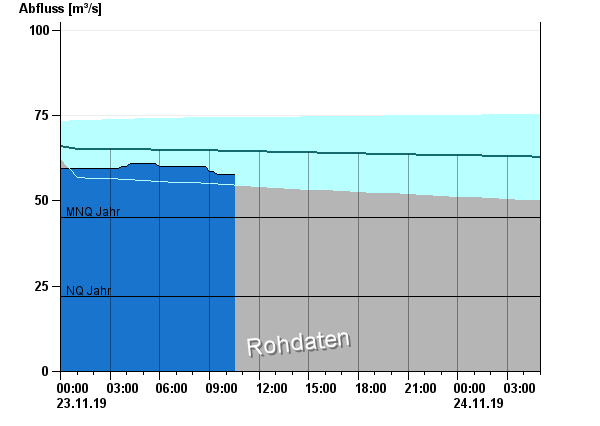

In [0]:
graphic_with_prediction_url = 'https://www.hnd.bayern.de/webservices/graphik.php?cache=hnd&statnr=10026301&thema=hochwasser.hauptwerte&wert=abfluss&trend=false&days=1&geber=25'
response = requests.get(graphic_with_prediction_url) 
with_prediction_img = Image.open(BytesIO(response.content))
with_prediction_img

Extract image parts.

In [0]:
axis_y_img = with_prediction_img.crop((20, 22, 50, 379))
axis_y_img

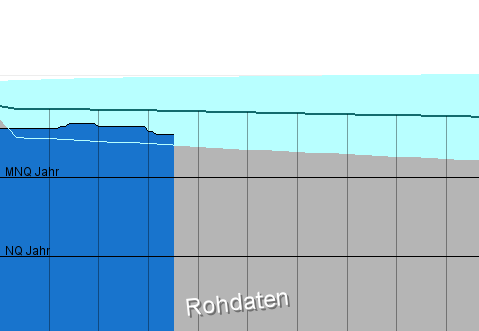

In [0]:
data_points_with_prediction_img = with_prediction_img.crop((61, 40, 540, 371))
data_points_with_prediction_img

# Data extraction & polish.

In [0]:
non_decimal = re.compile(r'[^\d.]+')
non_decimal.sub

axis_y_values = pytesseract.image_to_string(axis_y_img)
axis_y_values = filter(lambda x: x != '', axis_y_values.split('\n'))
axis_y_values = map(lambda x: non_decimal.sub('', x), axis_y_values)
axis_y_values = map(float, axis_y_values)
axis_y_values = list(axis_y_values)
max_y_value = axis_y_values[0] 
max_y_value

100.0

In [0]:
min_y_value = 0

In [0]:
amount_per_px_ratio = max_y_value/data_points_with_prediction_img.size[1]
# Rundungsfehler?
# For prediction
amount_per_px_ratio

0.3021148036253776

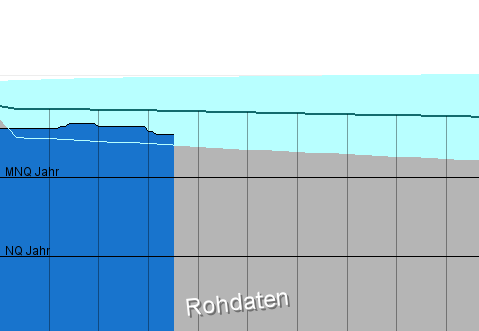

In [0]:
#data_points_img = img.crop((61, 22, 540, 371))
data_points_with_prediction_img

# Extract data points from image.

479 331


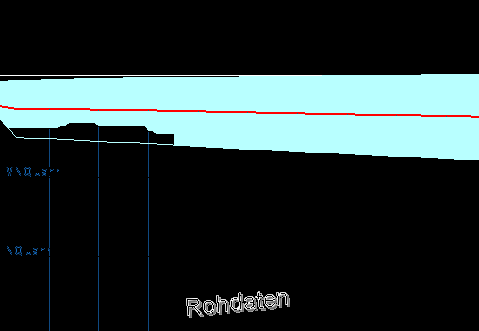

In [0]:
data_points_with_prediction_manip_img = data_points_with_prediction_img.copy()
pixels = data_points_with_prediction_manip_img.load() # create the pixel map

width = data_points_with_prediction_manip_img.size[0]
height = data_points_with_prediction_manip_img.size[1]

def get_pixel_brightness(pixel):
  return sum(pixel) / 3

print(width, height)

# List of tuples.
# 1: Pred. max, pred. min, pred / red)
column_info_list = list()
for i in range(0, width):    # for every col:i = 3  x_axis_count

  column_info = [math.nan, math.nan, math.nan]
  
  for j in range(0, height):    # For every row
    pixel = pixels[i,j]

    # Recolor pixels

    # Dunkelblau -> schwarz
    if (pixel == (255,255,255)):
      pixels[i,j] = (0,0,0)

    # Dunkelblau -> schwarz
    if (pixel == (24,116,205)):
      pixels[i,j] = (0,0,0)
    # Dunkelblau -> schwarz
    if (pixel == (42, 170, 255)):
      pixels[i,j] = (0,0,0)
   
    if (pixel == (181,181,181)):
      pixels[i,j] = (0,0,0)

    if (pixel == (114,114,114)):
      pixels[i,j] = (0,0,0)

    if (pixel == (115, 160, 160)):
      pixels[i,j] = (184, 255, 255)

    if (pixel == (11, 67, 68)):
      pixels[i,j] = (19, 107, 109)

    if (pixel == (237, 237, 237)):
      pixels[i,j] = (255, 255, 255)

    if (pixel == (19, 107, 109)):
      pixels[i,j] = (255, 0, 0)

    pixel = pixels[i,j]

    is_blue = pixel == (184, 255, 255)
    is_red = pixel == (255, 0, 0)

    normalized_y = height - j

    if is_blue:
      if math.isnan(column_info[0]):
        column_info[0] = normalized_y
      column_info[1] = normalized_y
     
    if is_red:
      column_info[2] = normalized_y

  column_info_list.append(column_info)

data_points_with_prediction_manip_img



In [0]:
y_vals = np.array(column_info_list) * amount_per_px_ratio
y_vals

array([[75.52870091, 64.04833837, 67.97583082],
       [75.52870091, 63.74622356, 67.97583082],
       [75.52870091, 63.44410876, 67.67371601],
       ...,
       [77.64350453, 51.96374622, 64.65256798],
       [77.64350453, 51.96374622, 64.65256798],
       [77.64350453, 51.96374622, 64.65256798]])

In [0]:
start_of_day = Delorean().truncate('day')

prediction_df = pd.DataFrame(y_vals, columns=['PredHigh', 'PredLow', "Pred"]).reset_index().dropna()
prediction_df

,index,PredHigh,PredLow,Pred
0,0,75.528701,64.048338,67.975831
1,1,75.528701,63.746224,67.975831
2,2,75.528701,63.444109,67.673716
3,3,75.528701,62.839879,67.673716
4,4,75.528701,62.537764,67.673716
...,...,...,...,...
474,474,77.643505,51.963746,64.652568
475,475,77.643505,51.963746,64.652568
476,476,77.643505,51.963746,64.652568
477,477,77.643505,51.963746,64.652568


In [0]:
prediction_df['Timestamp'] = prediction_df.apply(lambda row: start_of_day + timedelta(seconds=SECONDS_PER_PIXEL*row['index']), axis=1)
prediction_df['Timestamp'] = prediction_df.apply(lambda row: row['Timestamp'].datetime, axis=1)
prediction_df['Readable Timestamp'] = prediction_df.apply(lambda row: row['Timestamp'].strftime("%m/%d/%Y, %H:%M:%S"), axis=1)
prediction_df = prediction_df.tail(len(prediction_df) - 1)

In [0]:
prediction_df

,index,PredHigh,PredLow,Pred,Timestamp,Readable Timestamp
1,1,75.528701,63.746224,67.975831,2019-11-23 00:06:38.156682+00:00,"11/23/2019, 00:06:38"
2,2,75.528701,63.444109,67.673716,2019-11-23 00:13:16.313364+00:00,"11/23/2019, 00:13:16"
3,3,75.528701,62.839879,67.673716,2019-11-23 00:19:54.470046+00:00,"11/23/2019, 00:19:54"
4,4,75.528701,62.537764,67.673716,2019-11-23 00:26:32.626728+00:00,"11/23/2019, 00:26:32"
5,5,75.528701,62.235650,67.673716,2019-11-23 00:33:10.783410+00:00,"11/23/2019, 00:33:10"
...,...,...,...,...,...,...
474,474,77.643505,51.963746,64.652568,2019-11-25 04:25:26.267281+00:00,"11/25/2019, 04:25:26"
475,475,77.643505,51.963746,64.652568,2019-11-25 04:32:04.423963+00:00,"11/25/2019, 04:32:04"
476,476,77.643505,51.963746,64.652568,2019-11-25 04:38:42.580645+00:00,"11/25/2019, 04:38:42"
477,477,77.643505,51.963746,64.652568,2019-11-25 04:45:20.737327+00:00,"11/25/2019, 04:45:20"


Visualize extracted data.

In [0]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.models import DatetimeTickFormatter
output_notebook()

plot = figure(title='Sample Graph',x_axis_label = 'Timestamp',y_axis_label = 'Value', x_range=((start_of_day).datetime, (start_of_day + timedelta(days=3)).datetime), y_range=(0, max_y_value), x_axis_type='datetime')

plot.xaxis.formatter=DatetimeTickFormatter(
        hours=["%d %B %Y"],
        days=["%d %B %Y"],
        months=["%d %B %Y"],
        years=["%d %B %Y"],
    )

plot.line(prediction_df['Timestamp'], prediction_df['Pred'], line_width=2, line_color = 'red')
plot.line(prediction_df['Timestamp'], prediction_df['PredHigh'], line_width=2, line_color = 'blue')
plot.line(prediction_df['Timestamp'], prediction_df['PredLow'], line_width=2, line_color = 'blue')
show(plot)

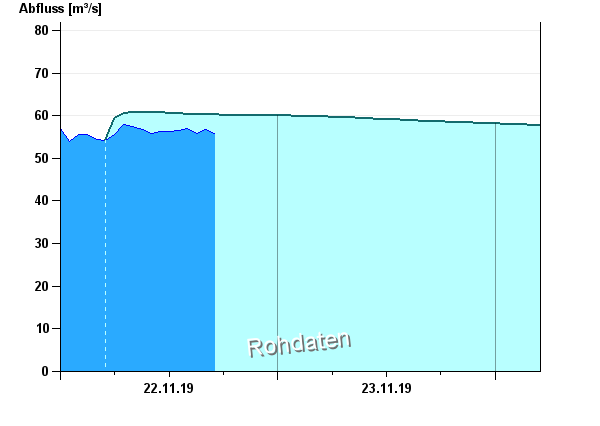

In [0]:
with_prediction_img

Export as CSV.

In [0]:
export_df = prediction_df.drop(['Timestamp'], axis=1)
export_df.to_csv('/content/out.csv', index=False)